# PokéBattle Bot Analysis Notebook

## Introduction

### Objectives
- Study the bot's main functions
- Analyze the decision-making logic
- Understand how moves and switches are evaluated


In [ ]:
import logging
import constants
import json
import math
import random
import time

from showdown.battle_bots.PokeBattle.main import BattleBot
from copy import deepcopy
from showdown.battle import Battle, Pokemon, Move
from showdown.battle_bots.PokeBattle import utility, state_eval
from showdown.battle_bots.PokeBattle.utility import game_over
from showdown.battle_bots.helpers import format_decision
from showdown.engine import helpers

# Maximum depth of exploration for minimax
MAX_DEPTH = 18

# 10 seconds of tolerance
TIME_TOLLERANCE = 10

# JSON file containing all moves
with open('data/moves.json', 'r') as f:
    all_moves = json.load(f)

## Best action selection

The `find_best_move` function is a core component of the Pokémon Showdown bot. It determines the optimal action (move or switch) during each turn by employing the Minimax algorithm and considering factors such as the Pokémon's health, available moves, and the overall game state.

### **Function Breakdown**

### Purpose
- To identify and execute the best possible action for the current game turn.
- To account for both short-term and long-term consequences of each action using simulation and evaluation.

### Key Steps

1. **Initial Validation**
   - Checks if the active Pokémon is alive:
     - If **not alive**, attempts to find the best switch option.
     - If no switches are available, returns an error or a placeholder action.
&nbsp;          
2. **Option Categorization**
    - Retrieves and categorizes all available actions into **moves** and **switches** using the `options_categorization` function.
    - Handles scenarios where switching is forced or no moves are available.
&nbsp;
3. **Move Evaluation with Minimax**
   - Combines all valid moves and switches into a single list.
   - Simulates each move using `apply_move` and evaluates its impact on the game state via the Minimax algorithm.
   - Restores the original game state after each simulation to avoid side effects.
&nbsp;
4. **Final Decision**
   - Selects the move or switch with the highest evaluated score.
   - Formats the decision and adjusts the remaining time.
   - Includes a fallback mechanism to randomly select an action if no optimal move is identified.

In [ ]:
def find_best_move(self) -> list[str]:
        """Finds best move or best switch using Minimax"""
        best_move = None
        max_value = float('-inf')
        self.start_time = time.time()  # timer start

        # Check if the Pokémon is alive or inactive
        if not self.user.active.is_alive():
            print("Error: active Pokémon is invalid or exhausted.") if self.debug else None
            switches = [f"{constants.SWITCH_STRING} {name}" for name in self.user.get_switches()]
            if switches:
                selected_switch = self.find_best_switch()
                if selected_switch:
                    self.apply_move(f"{constants.SWITCH_STRING} {selected_switch.name}")
                    self.time_remaining = utility.adjust_time(int(time.time() - self.start_time), self.time_remaining)
                    return format_decision(self, f"{constants.SWITCH_STRING} {selected_switch.name}")
            else:
                return ["no valid move or switch"]

        # Get all available moves and switches
        user_options, _ = self.get_all_options()
        print(f"Available moves: {user_options}") if self.debug else None
        moves, switches = BattleBot.options_categorization(user_options)

        # If we're forced to switch or there are no available moves the first switch is returned
        if self.force_switch or not moves:
            if not switches:
                print("Error: no available switch.") if self.debug else None
                self.time_remaining = utility.adjust_time(int(time.time() - self.start_time), self.time_remaining)
                return ["no valid move or switch"]

            switch = self.find_best_switch()
            if switch is None:
                switch = self.get_pkmn_by_switch(switches[0])

            selected_switch = format_decision(self, f"{constants.SWITCH_STRING} {switch.name}")
            print(f"Selected switch: {selected_switch}") if self.debug else None
            self.time_remaining = utility.adjust_time(int(time.time() - self.start_time), self.time_remaining)
            return selected_switch

        combined_options = moves.copy()
        combined_options.sort(key=lambda move: self.evaluate_move(move), reverse=True)
        switch = self.find_best_switch()
        if switch:
            combined_options.append(f"{constants.SWITCH_STRING} {switch.name}")

        # Execute MiniMax for each option
        for move in combined_options:
            saved_state = deepcopy(self)  # Saving the battle state
            self.apply_move(move)  # Choice simulation
            move_value = self.minimax(alpha=float('-inf'), beta=float('inf'))

            self.restore_state(saved_state)  # Battle state recovery

            if move_value > max_value:
                print(f"AAAAAA: {move_value}")
                max_value = move_value
                best_move = move

        # Select highest damage move
        if (best_move is not None or max_value > 0) and not game_over(self.user, self.opponent):
            selected_move = format_decision(self, best_move)
            print(f"Best found move: {selected_move}")
            self.time_remaining = utility.adjust_time(int(time.time() - self.start_time), self.time_remaining)
            return selected_move  # returns formatted decision

        # If no move is deemed "best," pick a random one
        if best_move is None and not game_over(self.user, self.opponent):  # If no best move was found by Minimax
            print(f"No best move found. Falling back to a random choice. {user_options}")
            best_move = random.choice(user_options)  # Random fallback choice
            selected_move = format_decision(self, best_move)
            self.time_remaining = utility.adjust_time(int(time.time() - self.start_time), self.time_remaining)
            return selected_move

---
## Advantages
- **Strategic Depth**: Evaluates both immediate and future outcomes of each action using Minimax.
- **Resilience**: Includes fallback mechanisms to handle edge cases (e.g., no valid moves).
- **Game State Simulation**: Ensures accurate decision-making by simulating and reverting actions.

## Limitations
- **Time Complexity**: Running Minimax for all actions can be computationally expensive, especially at higher depths.


---

## Simulation of the action

The `apply_move` function simulates the effect of a move or a switch during a battle, considering factors like type advantage, accuracy, and damage calculation.

### **Function Breakdown**

### Purpose
- To execute a move or switch action within a simulated game state.
- To evaluate the effects of the action, including status changes and damage dealt.

### Key Steps

1. **Handling Switches**
   - If the move is a switch, the function updates the `active` Pokémon without further calculations.
&nbsp;
2. **Move Accuracy**
   - Simulates whether the move hits, based on its accuracy.
   - If the move misses, the function logs the event and exits.
&nbsp;
3. **Damage Calculation**
   - Computes damage inflicted by the move using several factors:
     - Base power of the move.
     - Type effectiveness between the move and the opponent's Pokémon.
     - Levels of the attacker and defender.
&nbsp;
4. **Logging Results**
   - Outputs details about the damage inflicted and the type multiplier for debugging purposes.
&nbsp;
5. **Applying Status Effects**
   - If the move has a status effect (e.g., paralysis or burn), it is applied to the opponent.
   - Logs the status change for debugging.



In [ ]:
from showdown.battle_bots.PokeBattle.main import calculate_type_multiplier
from showdown.battle_bots.PokeBattle.main import calculate_damage

def apply_move(self, move_name: str) -> None:
        """Apply simulated move or switch considering type advantage"""
        move_part = move_name.split()

        if constants.SWITCH_STRING in move_name and len(move_part) > 1:
            self.user.active = Pokemon.from_switch_string(move_part[1])
            return

        # Damage, status effect and stats changes simulation
        move = Move(move_name)

        # Accuracy based move success rate calculation
        if random.randint(1, 100) > move.accuracy:
            if self.debug:
                print(f"{self.user.active.name} missed the move {move.name}.")
            return

        # Damage calculation considering types
        type_multiplier = calculate_type_multiplier(move.type, self.opponent.active.types)

        damage = calculate_damage(self.user.active, self.opponent.active, move)
        damage *= type_multiplier
        damage *= (self.user.active.level / self.opponent.active.level)

        self.opponent.active.hp -= math.floor(damage)
        print(f"{move.name} inflicted {damage:.2f} hp of damage to {self.opponent.active.name} with an "
              f"efficacy multiplier of {type_multiplier}.") if self.debug else None

        # The move has no secondary effects
        if move.status is not None:
            self.opponent.active.status = move.status
            print(f"{self.opponent.active.name} has been {move.status}!") if self.debug else None
        else:
            print(f"{self.user.active.name} missed the move {move.name}.") if self.debug else None

---

## Advantages
- **Comprehensive Simulation**: Covers accuracy, type advantages, and damage scaling based on levels.
- **Debugging Support**: Provides detailed logs for tracking actions and their effects.

## Limitations
- **No Secondary Effects**: The current implementation does not handle secondary effects like stat changes or healing.
- **Simplistic Status Application**: Assumes status effects apply directly without additional checks.

---

## Evaluation of the state
The `evaluate_state` function assesses the current battle state and assigns a numerical score to indicate the user's advantage or disadvantage. A higher score reflects a more favorable position for the user, while a lower score suggests a disadvantage. 

### **Function breakdown**

### Purpose
To evaluate the current battle state based on various factors such as health, level, type advantage, reserves, weather, and status conditions, helping to make informed decisions during battle.

### Key Steps
1. **Active Pokémon Status**:
    - Assigns a large penalty if the user's active Pokémon has fainted.
    - Assigns a high reward if the opponent's active Pokémon has fainted.
&nbsp;  
2. **Health and Level Difference**:
    - Scores the difference in percentage HP between the user's and opponent's active Pokémon.
    - Adds or subtracts points based on the level difference.
&nbsp;  
3. **Reserve Pokémon**:
    - Rewards having healthy Pokémon in the user's reserves.
    - Penalizes the opponent's healthy reserves.
&nbsp;  
4. **Type Advantage**:
    - Rewards having a type advantage and penalizes type disadvantage based on a multiplier.
&nbsp;
5. **Weather Conditions**:
    - Adjusts the score based on how weather impacts the user's and opponent's Pokémon.
&nbsp;
6. **Status Conditions**:
    - Penalizes status conditions on the user's active Pokémon (e.g., paralysis, burn).
    - Rewards status conditions on the opponent's active Pokémon.
&nbsp;
7. **Stat Boosts**:
    - Evaluates boosts or reductions in stats, rewarding moderate boosts and penalizing extreme ones or reductions.
&nbsp;
8. **Healing Move Usage**:
    - Penalizes using healing moves unnecessarily (e.g., if the user's HP is already high).
&nbsp;
9. **Worst-Case Opponent Moves**:
    - Considers the most damaging move the opponent could use and adjusts the score accordingly.
&nbsp;
10. **Random Tie-Breaker**:
    - Adds a small random factor to break ties in evaluations.
&nbsp;
11. Returns a numerical score representing the overall battle state. A positive score indicates an advantage, while a negative score indicates a disadvantage.

In [ ]:
def evaluate_state(self) -> float:
        """Battle state evaluation"""
        score = 0

        # Check if active Pokémon are alive
        if not self.user.active.is_alive():
            return float('-inf')  # Heavy penalty if user's active Pokémon is fainted
        if not self.opponent.active.is_alive():
            return float('inf')  # High reward if opponent's active Pokémon is fainted

        # 1. Scores by HP difference and level
        hp_percent_user = self.user.active.hp / self.user.active.max_hp
        hp_percent_opponent = self.opponent.active.hp / self.opponent.active.max_hp
        level_diff = self.user.active.level - self.opponent.active.level
        score += (hp_percent_user - hp_percent_opponent) * 50
        score += level_diff * 5

        # 2. Bonus/penalty for alive reserve
        user_reserve_score = sum(10 for p in self.user.reserve if p.hp > 0)
        opponent_reserve_score = sum(10 for p in self.opponent.reserve if p.hp > 0)
        score += user_reserve_score - opponent_reserve_score

        # 3. Bonus/penalty for type advantage/disadvantage
        type_advantage_multiplier = calculate_type_multiplier(self.user.active.types[0], self.opponent.active.types)
        if type_advantage_multiplier > 1:
            score += 120 * type_advantage_multiplier  # Bonus for type advantage
        elif type_advantage_multiplier < 1 and type_advantage_multiplier != 0:
            score -= 100 * (1 / type_advantage_multiplier)  # Penalty for type disadvantage
        else:
            score -= 150

        # 4. Bonus for weather conditions
        score += state_eval.weather_condition(self.user.active, self.opponent.active, self.weather)

        # 5. Penalty for status conditions
        status_penalty = {
            constants.PARALYZED: 30,
            constants.POISON: 35,
            'badly poisoned': 40,
            constants.BURN: 25,
            constants.SLEEP: 60,
            constants.FROZEN: 70,
        }
        score -= status_penalty.get(self.user.active.status, 0)
        score += status_penalty.get(self.opponent.active.status, 0)

        # 6. Evaluate user's boost status
        for boost, value in self.user.active.boosts.items():
            if value < 0:
                score -= 20
            elif 0 < value <= 4:
                score += 30
            elif value > 4:
                score -= 10

        # 7. Evaluate user's boost status
        status_move = [move for move in self.user.active.moves if
                       "heal" in all_moves.get(move.name.lower(), {}).get("flags", {})]
        if status_move and hp_percent_user >= 0.85:
            score -= 120

        # 8. Integrate worst-case opponent move analysis
        opponent_moves = self.opponent.active.moves
        if opponent_moves:
            worst_opponent_score = min(
                self.evaluate_move_risk(move, self.user.active) for move in opponent_moves
            )
            score += worst_opponent_score  # Adjust score with worst-case scenario

        # 9. Random factor for tie-breaking decisions
        score += random.uniform(-1, 1)

        return score

---

## Advantages
- **Comprehensive Evaluation**: The function considers a wide range of factors, including HP, levels, type advantages, weather, and status effects, providing a nuanced assessment of the battle state.
- **Opponent Move Risk Analysis**: It accounts for worst-case opponent moves, ensuring defensive awareness and improving the reliability of its state evaluation.
## Limitations
- **High Computational Complexity**: Evaluating multiple factors, especially worst-case opponent moves, can be computationally intensive, leading to slower decision-making.
- **Static Weighting Issues**: Some factors, like type effectiveness or status penalties, are given fixed weights that may not reflect their situational importance, potentially skewing the evaluation.

---

## Best Pokémon Selection
The `find_best_switch` function identifies the best Pokémon from the user's team to switch into battle based on their resistance to the opponent's active Pokémon's types and the strength of their moves.

### **Function breakdown**

### Purpose
To find the optimal Pokémon to switch into the battle based on a combination of type resistance and move effectiveness.

### Key Steps
1. Iterates through all the user's available Pokémon switches.
2. For each Pokémon, calculates a resistance score based on its types and the opponent's Pokémon's types using a type-effectiveness table.
3. Keeps track of Pokémon with the highest resistance score. If multiple Pokémon have the same score, they are considered as candidates for the best switch.
4. Among the candidates, evaluates their potential move scores with the `pokemon_score_moves` function and selects the one with the highest move score.
5. Returns the best Pokémon to switch in. If no suitable Pokémon is found, it returns None. 

### Error Handling
Ensures Pokémon exist in the team before evaluation and handles cases where no suitable candidates are found.


In [ ]:
def find_best_switch(self) -> Pokemon | None:
        # Find the best Pokémon in the team to make the switch.
        best_pokemon = None
        max_score = float('-inf')
        best_move_score = float('-inf')
        best_pokemon_candidates = []

        opponent_types = self.opponent.active.types

        for switch in self.user.get_switches():
            pokemon_to_switch = self.get_pokemon_by_name(switch)

            if pokemon_to_switch is None:
                if self.debug:
                    print(f"Error: Pokémon {switch} not found in the user's reserve.")
                    continue

            # Evaluate the resistance of the reserve Pokémon against the opponent's type
            resistance = 0
            resistance += sum(constants.TYPE_EFFECTIVENESS.get(switch_type, {}).get(opponent_type, 1)
                              for opponent_type in opponent_types
                              for switch_type in pokemon_to_switch.types)

            # Combine resistance and move score for overall evaluation
            total_move_score = resistance

            if total_move_score > max_score:
                max_score = total_move_score
                best_pokemon_candidates = [pokemon_to_switch]  # Reset the list of best candidates
            elif total_move_score == max_score:
                best_pokemon_candidates.append(pokemon_to_switch)  # Add to the list of best candidates

        # Choose the best Pokémon from the candidates
        if best_pokemon_candidates:
            # if we have more than one candidate choose a heuristic to select the best Pokémon
            # we choose the Pokémon with the best move
            for pokemon in best_pokemon_candidates:

                # Calculate the move score
                move_score = self.pokemon_score_moves(pokemon_to_switch.name)

                if move_score > best_move_score:
                    best_move_score = move_score
                    best_pokemon = pokemon
            # if self.debug:
            print(f"Best switch: {best_pokemon.name} with a total score of {max_score}") if self.debug else None
        elif self.debug:
            print("No suitable Pokémon found.") if self.debug else None

## Evaluation of Pokémon Moves
The `pokemon_score_moves` function evaluates the effectiveness of a Pokémon's moves and returns a score that reflects the quality of its best move.

### **Function breakdown**

### Purpose
To assess the strength of a Pokémon's moves, accounting for move power and accuracy, and return a score for the best move.

### Key Steps
1. Retrieves the Pokémon object by its name.
2. Iterates through the Pokémon's available moves.
3. For each move:
    - Evaluates its base effectiveness using the `evaluate_move` method.
    - Adjusts the move's score based on its accuracy.
4. Tracks the highest move score during iteration.
5. Returns the total score of the best move for the Pokémon.

### Error Handling
If the Pokémon cannot be found, prints an error message and returns a score of 0.


In [ ]:
def pokemon_score_moves(self, pokemon_name: str) -> float:
        """Find if the moves of the Pokémon are good or not"""
        pokemon = self.get_pokemon_by_name(pokemon_name)  # Get Pokémon object from the name
        max_score = float('-inf')

        if pokemon is None:
            print(f"Error: Pokémon {pokemon_name} not found.")
            return 0

        total_score = 0

        for move in pokemon.moves:
            move_score = self.evaluate_move(move)
            accuracy_multiplier = move.accuracy / 100 if isinstance(move.accuracy,
                                                                    int) else 1  # Assuming accuracy is between 0 and
            # 100 (adjust the move score based on the accuracy of the move)
            total_score = move_score * accuracy_multiplier

            if total_score > max_score:
                max_score = total_score

        print(f"Total score for {self.user.name}: {total_score}") if self.debug else None

        return total_score

---

## Advantages
- **Strategic Decision-Making**: Incorporates the quality of a Pokémon's moves as a secondary heuristic to ensure that the selected Pokémon is not only defensive but also offensively viable.
- **Move Evaluation**: Considers both move effectiveness (via evaluate_move) and accuracy, offering a realistic assessment of each move's reliability.

## Limitations
- **Limited Context Awareness**: The function doesn't account for battle-specific conditions like weather, stat boosts, or status effects, which can heavily influence optimal switches.
-- **Candidate Refinement**: During the candidate refinement phase in find_best_switch, the pokemon_score_moves function is called for each candidate Pokémon. If multiple candidates have identical resistance scores, this could lead to redundant evaluations.

---

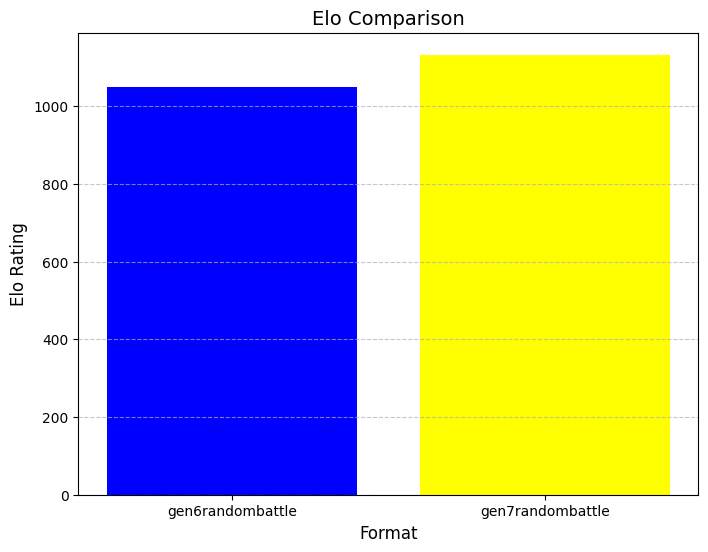

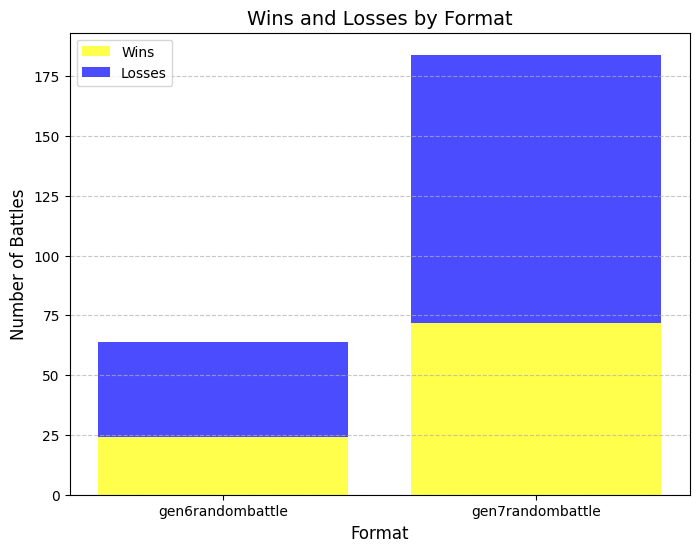

             Format   Elo   GXE  Glicko-1   W    L
0  gen6randombattle  1049  24.6      1289  24   40
1  gen7randombattle  1132  24.5      1288  72  112


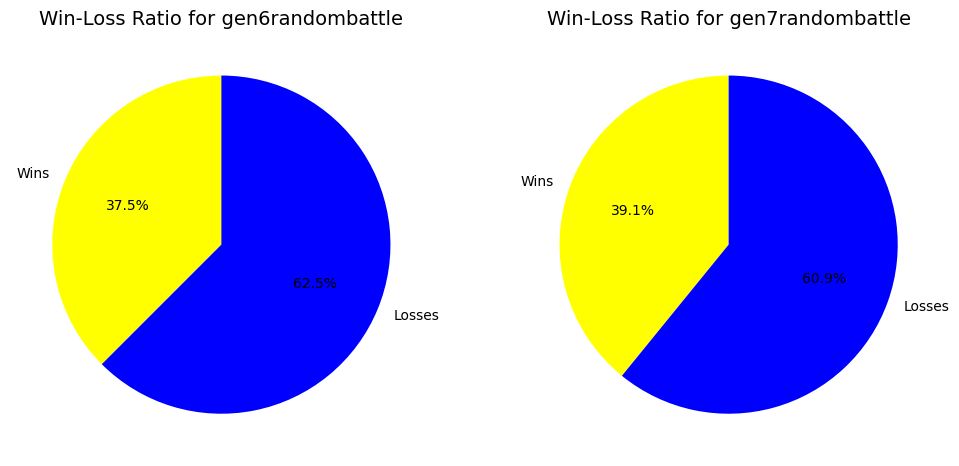

In [8]:
# Pokémon Showdown Ladder Data Analysis

## Importing Libraries
import matplotlib.pyplot as plt
import pandas as pd


## Data Preparation
data = {
    "Format": ["gen6randombattle", "gen7randombattle"],
    "Elo": [1049, 1132],
    "GXE": [24.6, 24.5],
    "Glicko-1": [1289, 1288],
    "W": [24, 72],
    "L": [40, 112]
}

# Create a DataFrame
df = pd.DataFrame(data)


## Visualizing Elo Comparison
plt.figure(figsize=(8, 6))
plt.bar(df["Format"], df["Elo"], color=['blue', 'yellow'])
plt.title("Elo Comparison", fontsize=14)
plt.ylabel("Elo Rating", fontsize=12)
plt.xlabel("Format", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Visualizing Wins and Losses
plt.figure(figsize=(8, 6))
plt.bar(df["Format"], df["W"], label='Wins', color='yellow', alpha=0.7)
plt.bar(df["Format"], df["L"], label='Losses', color='blue', alpha=0.7, bottom=df["W"])
plt.title("Wins and Losses by Format", fontsize=14)
plt.ylabel("Number of Battles", fontsize=12)
plt.xlabel("Format", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Pie charts for win-loss ratio
labels = ['Wins', 'Losses']
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for gen6randombattle
sizes_gen6 = [df.loc[0, 'W'], df.loc[0, 'L']]
axes[0].pie(sizes_gen6, labels=labels, autopct='%1.1f%%', startangle=90, colors=['yellow', 'blue'])
axes[0].set_title("Win-Loss Ratio for gen6randombattle", fontsize=14)

# Pie chart for gen7randombattle
sizes_gen7 = [df.loc[1, 'W'], df.loc[1, 'L']]
axes[1].pie(sizes_gen7, labels=labels, autopct='%1.1f%%', startangle=90, colors=['yellow', 'blue'])
axes[1].set_title("Win-Loss Ratio for gen7randombattle", fontsize=14)

## Displaying Data
print(df)


